# Create lithogenic and biogenic particle fields for Pb scavenging

BLING ends in April, 2019

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import xarray as xr
import cmocean
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator

%matplotlib inline

#### Parameters / settings:

In [2]:
land_color = '#a9a7a2'

# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179
isize = imax - imin
jsize = jmax - jmin

#### Load files

In [3]:
mesh         = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon     = mesh['nav_lon'].values
mesh_lat     = mesh['nav_lat'].values
mesh_bathy   = mesh['tmask'][0,:,:,:].values
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = mesh['nav_lev'].values

In [4]:
# BLING:
folder_EPM101 = '/data/brogalla/ANHA4/BLING-EPM101/'
dset          = xr.open_dataset(f'/ocean/brogalla/GEOTRACES/BLING-EPM101/ANHA4-EPM101_y2002m08d13_gridB.nc')
ANHA4_lons    = dset['nav_lon'].values
ANHA4_lats    = dset['nav_lat'].values
ANHA4_depths  = dset['deptht'].values

In [5]:
# Mn for surface particle field:
dset_ANHA12 = xr.open_dataset('/data/brogalla/run_storage/Mn-extended-domain-202210/oMn_y2002m01.nc')
ANHA12_lons = mesh_lon[imin:imax,jmin:jmax]
ANHA12_lats = mesh_lat[imin:imax,jmin:jmax]

#### Functions:

In [6]:
def find_max_bio(year, month):
    # BLING:
    file_EPM101  = f'/data/brogalla/ANHA4/BLING-EPM101/ANHA4-EPM101_y{year}m{month:02}.nc'
    dset_bio     = xr.open_dataset(f'{file_EPM101}')
    jp_pop_ANHA4 = dset_bio['jp_pop'][:,:,:].values
    
    # Convert vertical flux of particulate organic phosphate to content by dividing by the sinking rate:
    # Sinking rate info comes from pg. 43-44 Laura Castro de la Guardia's thesis
    wsink              = np.ones(depths.shape)*16/(3600*24) # convert from m/day to m/s
    wsink[depths > 80] = (0.05*(depths[depths > 80]-80)+16)/(3600*24) 
    pop_ANHA4          = np.array([jp_pop_ANHA4[d,:,:] / wsink[d] for d in range(0,len(depths))])
    
    # interpolate from ANHA4 to ANHA12 grid:
    ANHA12_jp_pop = np.empty((50,isize,jsize))
    for depth in range(0,50):
        interpolator   = LinearNDInterpolator(tri, pop_ANHA4[depth,:,:].flatten())    
    
        ANHA12_jp_pop[depth,:,:] = interpolator(np.array([ANHA12_lons.flatten(), ANHA12_lats.flatten()]).transpose()).reshape(ANHA12_lons.shape)

    ANHA12_jp_pop[ANHA12_jp_pop < 0] = 0

    max_jp_pop = np.amax(ANHA12_jp_pop)

    return max_jp_pop

def find_max_litho(year, month):
    # Mn for surface particle field:
    folder_Mn   = f'/data/brogalla/run_storage/Mn-extended-domain-202210/'
    dset_ANHA12 = xr.open_dataset(f'{folder_Mn}oMn_y{year}m{month:02}.nc')
    ANHA12_Mn   = dset_ANHA12['oxidismn'][:,:,:].values 
    
    max_litho = np.amax(ANHA12_Mn)
    
    return max_litho

In [7]:
def save_file(folder, litho_array, bio_array, year, month):   
    
    file_write = xr.Dataset(
        {'lithogenic' : (("deptht","y","x"), litho_array),
         'biogenic' : (("deptht","y","x"), bio_array)}, 
        coords = {
            "time_counter": np.zeros(1),
            "deptht": depths,
            "y": np.zeros(mesh_lat.shape[0]),
            "x": np.zeros(mesh_lon.shape[1])},
    )
    file_write.to_netcdf(f'{folder}Pb_scavenging_y{year}m{month:02}.nc', \
                         unlimited_dims='time_counter')

    return

In [8]:
# interpolate from ANHA4 to ANHA12 grid:
tri = Delaunay(np.array([ANHA4_lons.flatten(), ANHA4_lats.flatten()]).transpose())  # Compute the triangulation

def load_bio(year, month):
    # BLING:
    file_EPM101  = f'/data/brogalla/ANHA4/BLING-EPM101/ANHA4-EPM101_y{year}m{month:02}.nc'
    dset_bio     = xr.open_dataset(f'{file_EPM101}')
    jp_pop_ANHA4 = dset_bio['jp_pop'][:,:,:].values
    
    # Convert vertical flux of particulate organic phosphate to content by dividing by the sinking rate:
    # Sinking rate info comes from pg. 43-44 Laura Castro de la Guardia's thesis
    wsink              = np.ones(depths.shape)*16/(3600*24) # convert from m/day to m/s
    wsink[depths > 80] = (0.05*(depths[depths > 80]-80)+16)/(3600*24) 
    pop_ANHA4          = np.array([jp_pop_ANHA4[d,:,:] / wsink[d] for d in range(0,len(depths))])
    
    # Fill NaN values with mean
    pop_ANHA4[np.isnan(pop_ANHA4)] = np.nanmean(pop_ANHA4)
    pop_ANHA4[pop_ANHA4 < 0] = 0
    
    # interpolate from ANHA4 to ANHA12 grid:
    ANHA12_jp_pop = np.empty((50,isize,jsize))
    for depth in range(0,50):
        interpolator   = LinearNDInterpolator(tri, pop_ANHA4[depth,:,:].flatten())    
    
        ANHA12_jp_pop[depth,:,:] = interpolator(np.array([ANHA12_lons.flatten(), ANHA12_lats.flatten()]).transpose()).reshape(ANHA12_lons.shape)

    return ANHA12_jp_pop

def load_litho(year, month):
    # Mn for surface particle field:
    folder_Mn   = f'/data/brogalla/run_storage/Mn-extended-domain-202210/'
    dset_ANHA12 = xr.open_dataset(f'{folder_Mn}oMn_y{year}m{month:02}.nc')
    ANHA12_Mn   = dset_ANHA12['oxidismn'][:,:,:].values 
    
    return ANHA12_Mn

In [11]:
from scipy import ndimage as nd

def fill(data, invalid=None):
    """
    Replace the value of invalid 'data' cells (indicated by 'invalid') 
    by the value of the nearest valid data cell

    Input:
        data:    numpy array of any dimension
        invalid: a binary array of same shape as 'data'. True cells set where data
                 value should be replaced.
                 If None (default), use: invalid  = np.isnan(data)

    Output: 
        Return a filled array. 
    """
    #import numpy as np
    #import scipy.ndimage as nd

    if invalid is None: invalid = np.isnan(data)

    ind = nd.distance_transform_edt(invalid, return_distances=False, return_indices=True)
    return data[tuple(ind)]

In [12]:
def create_particle_fields(year, month, max_bio=np.nan, max_litho=np.nan, save=False, beta=np.nan):

    ANHA12_biogenic = load_bio(year, month)
    ANHA12_litho    = load_litho(year, month)
    
    # particles: normalize by maximum value within domain over the course of the full time series
    normalized_biogenic   = ANHA12_biogenic / max_bio 
    normalized_lithogenic = ANHA12_litho / max_litho 

    # initialize arrays with some small value, then fill with normalized particle fields:
    lithogenic_particles = np.ones(mesh_bathy.shape)*0.10
    biogenic_particles   = np.ones(mesh_bathy.shape)*0.10
    lithogenic_particles[:,imin:imax,jmin:jmax] = normalized_lithogenic
    biogenic_particles[:,imin:imax,jmin:jmax]   = normalized_biogenic
    
    # put an upper limit of biogenic particle contribution:
    biogenic_particles[(biogenic_particles > 0.06)] = 0.06 

    # Fill any weird values 
    # https://stackoverflow.com/questions/3662361/fill-in-missing-values-with-nearest-neighbour-in-python-numpy-masked-arrays
#     biogenic_particles_masked = np.ma.masked_where(biogenic_particles<=0, biogenic_particles)
    biogenic_particles_filled = fill(biogenic_particles, invalid=(biogenic_particles<=0))
    biogenic_particles_filled[(mesh_bathy < 0.1)] = 0.00 # fill land with zeros
    
#     biogenic_particles[biogenic_particles <= 0]          = 0.10
#     biogenic_particles[np.isnan(biogenic_particles)]     = 0.10
    
    lithogenic_particles[lithogenic_particles <= 0]      = 0.0
    lithogenic_particles[np.isnan(lithogenic_particles)] = 0.0
    
    if np.any(lithogenic_particles < 0):
        print('negative lithogenic')
    if np.any(biogenic_particles_filled < 0):
        print('negative biogenic')
    
    if save:
        if np.isnan(beta):
            print('need to define beta')
        else:
            folder ='/ocean/brogalla/GEOTRACES/data/Pb-tuning-202210/new-bio-proxy/upper-limit/'
            betas  = [0.005]
            save_file(f'{folder}', lithogenic_particles*betas[0], biogenic_particles_filled*(1-betas[0]), year, month)
#             save_file(f'{folder}particle001/' , lithogenic_particles*betas[1], biogenic_particles*(1-betas[1]), year, month)
    
    return lithogenic_particles, biogenic_particles_filled

#### Calculations

In [38]:
# Maximum value in file: 
n=0
max_bio_list   = np.empty((12*19)); max_bio_list[:]   = np.nan;
max_litho_list = np.empty((12*19)); max_litho_list[:] = np.nan;
for year in range(2002, 2021):
    print(year)
    for month in range(1,13):
        try:
            max_bio = find_max_bio(year, month)
        except:
            max_bio = np.nan
            
        try:
            max_litho = find_max_litho(year, month)
        except:
            max_litho = np.nan
            
        max_bio_list[n]   = max_bio            
        max_litho_list[n] = max_litho
        
        n+=1

2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


Create particle fields and save:

In [15]:
for year in range(2014, 2015):
    for month in range(12,13):
        print(year, month)
        litho, bio = create_particle_fields(year, month, max_bio=2.54467e-4, max_litho=1.83314e-7, save=True, beta=0.00)

2014 12


#### Extra: compare ANHA4 original field and interpolated field:
Look basically the same (except for ANHA4 grid artefact thingy

In [13]:
year=2015; month=3;
file_EPM101 = f'/data/brogalla/ANHA4/BLING-EPM101/ANHA4-EPM101_y{year}m{month:02}.nc'
dset_bio    = xr.open_dataset(f'{file_EPM101}')
bio_ANHA4   = dset_bio['jp_pop'][:,:,:].values
    
wsink              = np.ones(depths.shape)*16/(3600*24) # convert from m/day to m/s
wsink[depths > 80] = (0.05*(depths[depths > 80]-80)+16)/(3600*24) 
pop_ANHA4          = np.array([bio_ANHA4[d,:,:] / wsink[d] for d in range(0,len(depths))])

In [16]:
print(np.nanmin(pop_ANHA4))

0.0


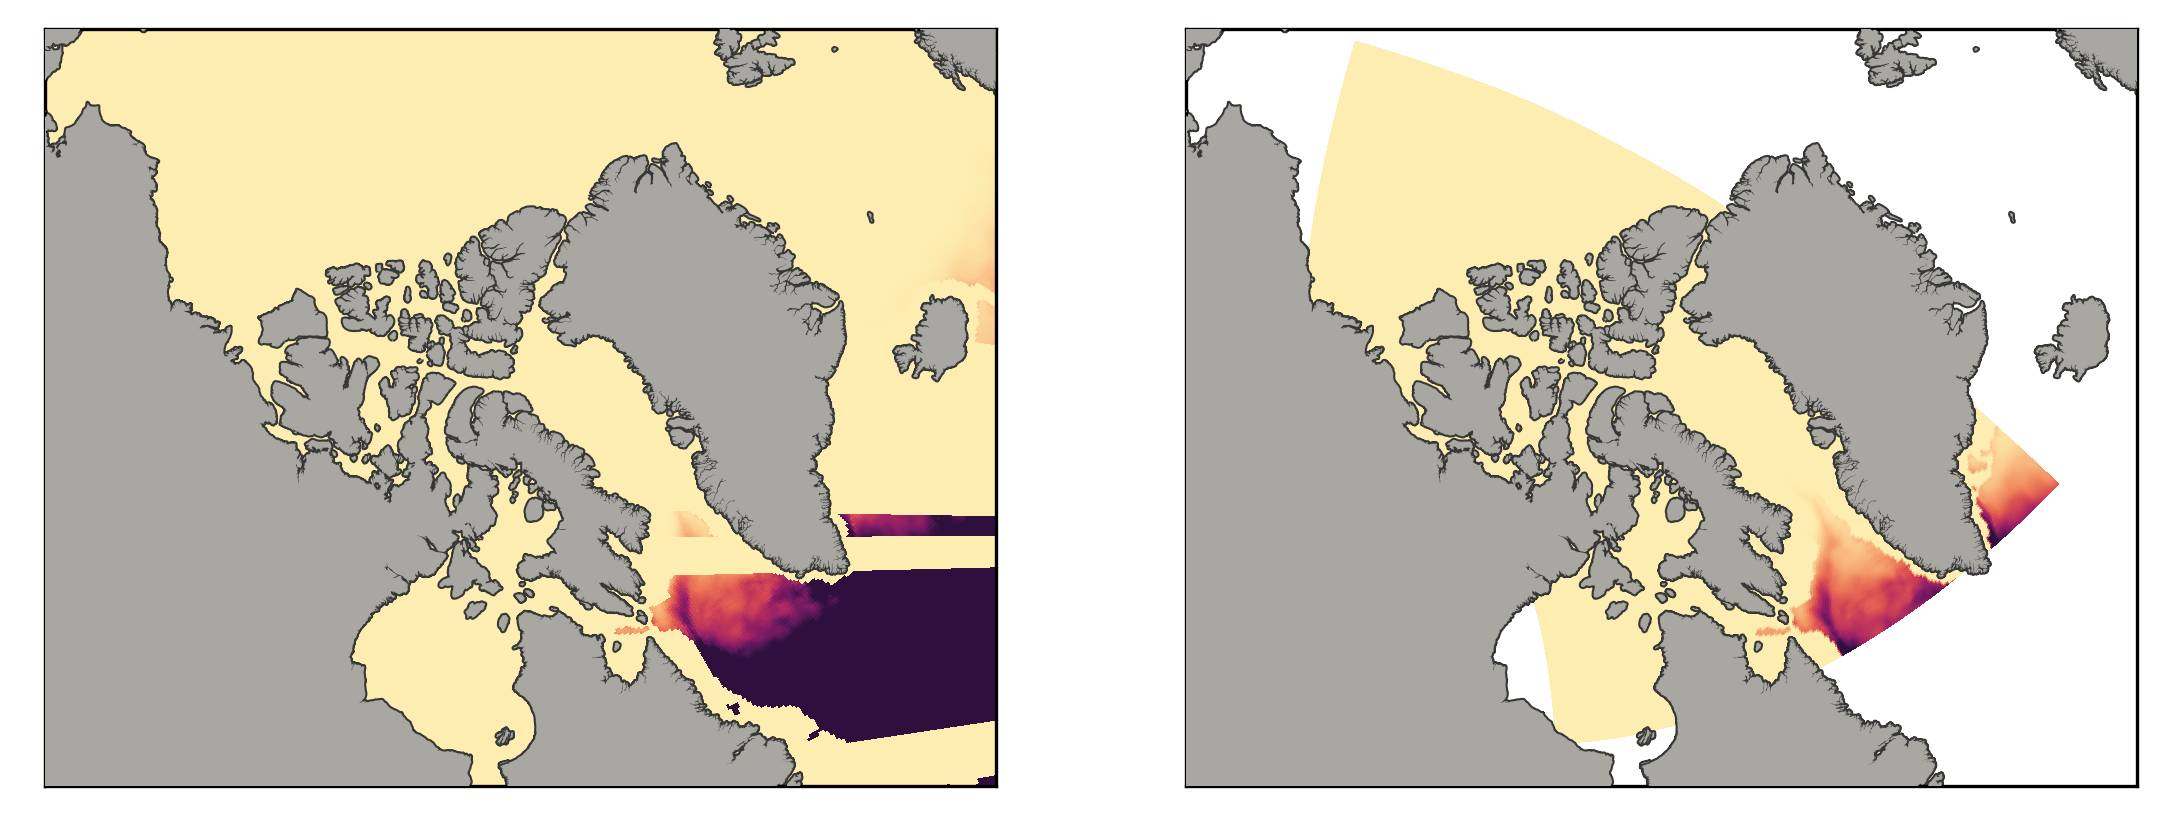

In [63]:
fig, ax = plt.subplots(1,2,figsize=(9,4),dpi=300)

proj1=Basemap(projection='eqdc',lat_0 = 73, lon_0 = -78, resolution='i', width=5.4e6, height=4.3e6, ax=ax[0])
proj1.drawcoastlines(color='#373736', linewidth=1.0);
proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=5);

proj2=Basemap(projection='eqdc',lat_0 = 73, lon_0 = -78, resolution='i', width=5.4e6, height=4.3e6, ax=ax[1])
proj2.drawcoastlines(color='#373736', linewidth=1.0);
proj2.fillcontinents(color=land_color, lake_color=land_color, zorder=5);

xANHA4 , yANHA4  = proj1(ANHA4_lons , ANHA4_lats)
xANHA12, yANHA12 = proj2(ANHA12_lons, ANHA12_lats)

# CB1 = proj1.contourf(xANHA4, yANHA4, pop_ANHA4[30,:,:], levels=100, cmap=cmocean.cm.matter, vmin=0, vmax=1e-6)
CB1 = proj1.pcolormesh(xANHA4, yANHA4, pop_ANHA4[30,:,:], cmap=cmocean.cm.matter, vmin=0, vmax=1e-7)
CB2 = proj2.pcolormesh(xANHA12, yANHA12, bio[30,:,:], cmap=cmocean.cm.matter, vmin=0, vmax=1e-7)

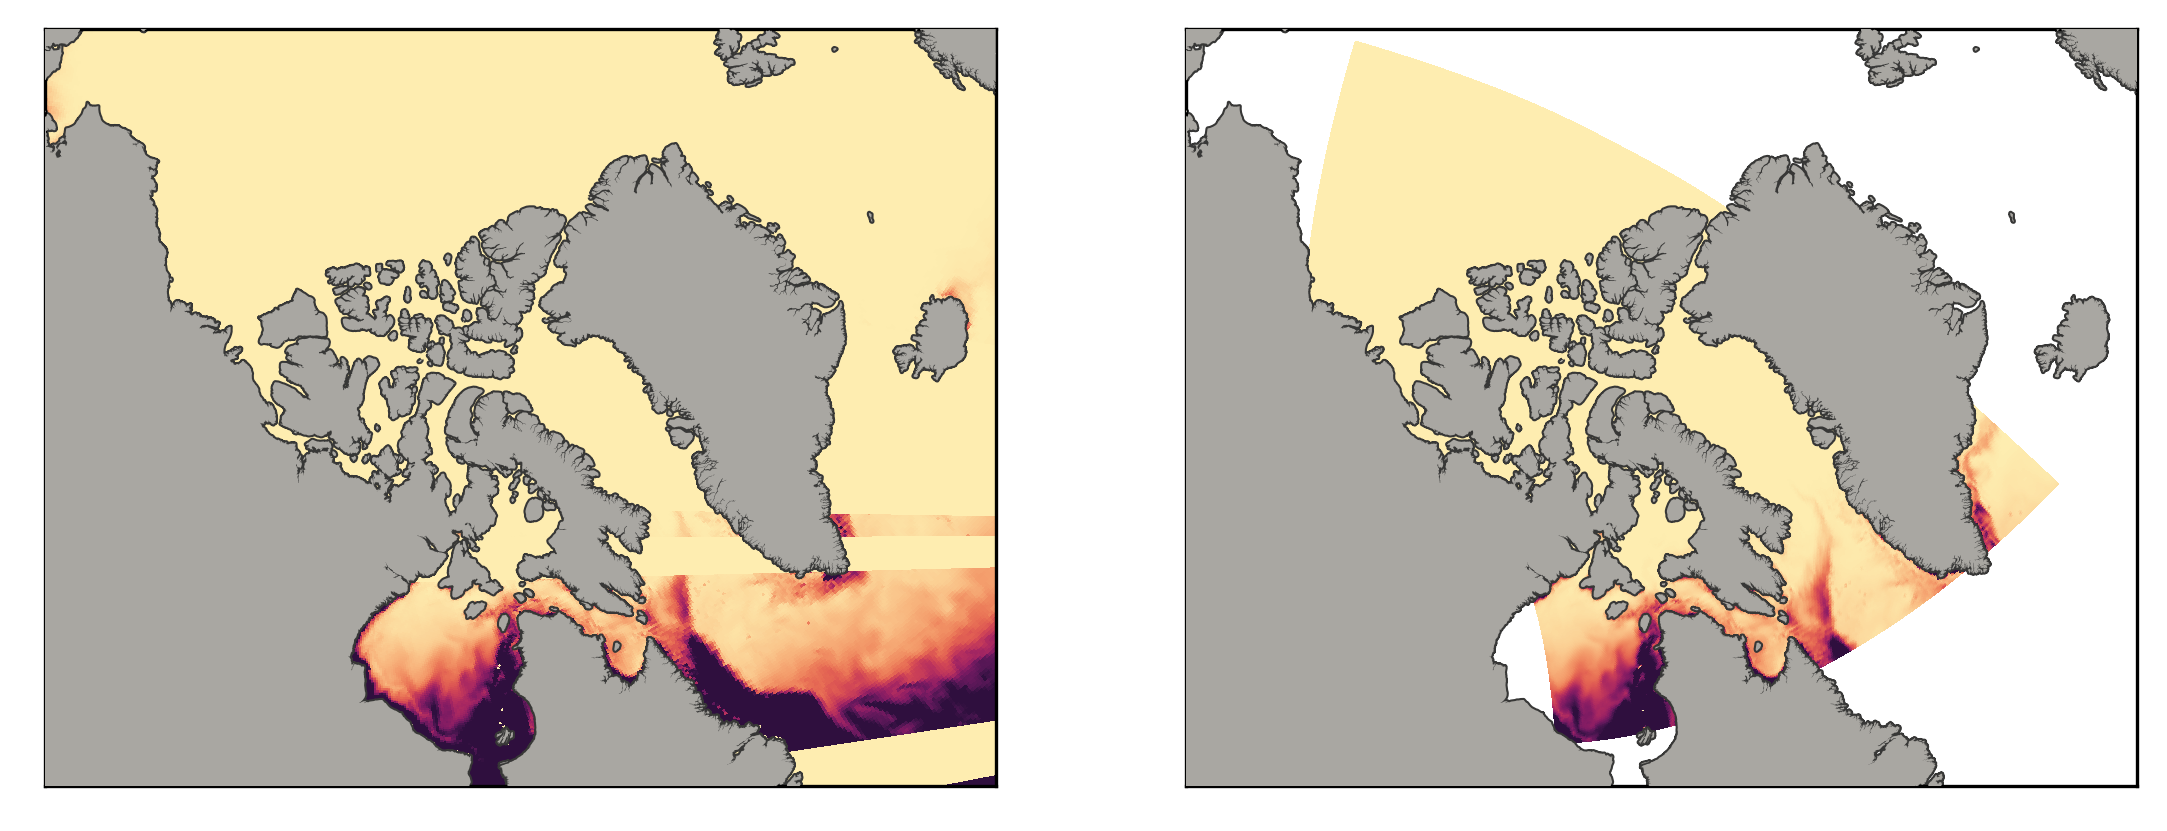

In [64]:
fig, ax = plt.subplots(1,2,figsize=(9,4),dpi=300)

proj1=Basemap(projection='eqdc',lat_0 = 73, lon_0 = -78, resolution='i', width=5.4e6, height=4.3e6, ax=ax[0])
proj1.drawcoastlines(color='#373736', linewidth=1.0);
proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=5);

proj2=Basemap(projection='eqdc',lat_0 = 73, lon_0 = -78, resolution='i', width=5.4e6, height=4.3e6, ax=ax[1])
proj2.drawcoastlines(color='#373736', linewidth=1.0);
proj2.fillcontinents(color=land_color, lake_color=land_color, zorder=5);

xANHA4 , yANHA4  = proj1(ANHA4_lons , ANHA4_lats)
xANHA12, yANHA12 = proj2(ANHA12_lons, ANHA12_lats)

# CB1 = proj1.contourf(xANHA4, yANHA4, pop_ANHA4[0,:,:], levels=100, cmap=cmocean.cm.matter, vmin=0, vmax=1e-6)
CB1 = proj1.pcolormesh(xANHA4, yANHA4, pop_ANHA4[0,:,:], cmap=cmocean.cm.matter, vmin=0, vmax=1e-7)
CB2 = proj2.pcolormesh(xANHA12, yANHA12, bio[0,:,:], cmap=cmocean.cm.matter, vmin=0, vmax=1e-7)